In [14]:
import numpy as np
import torch
import nltk
import json
import bert_score
import rouge
from collections import Counter
import matplotlib.pyplot as plt
from statistics import stdev
from scipy.stats import spearmanr

%matplotlib inline

## Compute

In [28]:
with open("data/combined.json") as f:
    data = json.load(f)

In [29]:
scorer = bert_score.BERTScorer(model_type="microsoft/deberta-xlarge-mnli", lang="en", rescale_with_baseline=True)

Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.bias', 'classifier.bias', 'classifier.weight', 'pooler.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
evaluator = rouge.Rouge(metrics=["rouge-n", "rouge-l"], max_n=2, limit_length=False, apply_avg=True, stemming=True, ensure_compatibility=True)

In [31]:
def stem(x):
    return Counter(evaluator.stem_tokens(evaluator.tokenize_text(x.lower())))


def calc_ds(summ_a, summ_b, summ_comm):
    s_a, s_b, s_c = stem(summ_a), stem(summ_b), stem(summ_comm)
    nr = sum((s_a & s_b).values()) + sum((s_a & s_c).values()) + sum((s_b & s_c).values()) - 2.0 * sum((s_a & s_b & s_c).values())
    dr = sum((s_a | s_b | s_c).values())
    return 1.0 - (nr / dr)

 
def calc_bs(summ_a, summ_b, summ_comm):
    ab = [s.detach().numpy()[0] for s in scorer.score([summ_a], [summ_b])]
    ba = [s.detach().numpy()[0] for s in scorer.score([summ_a], [summ_b])]
    a_comm = [s.detach().numpy()[0] for s in scorer.score([summ_a], [summ_comm])]
    comm_a = [s.detach().numpy()[0] for s in scorer.score([summ_comm], [summ_a])]
    b_comm = [s.detach().numpy()[0] for s in scorer.score([summ_b], [summ_comm])]
    comm_b = [s.detach().numpy()[0] for s in scorer.score([summ_comm], [summ_b])]
    a_b = (np.array(ab) + np.array(ba)) / 2.0
    a_c = (np.array(a_comm) + np.array(comm_a)) / 2.0
    b_c = (np.array(b_comm) + np.array(comm_a)) / 2.0
    return (a_b + a_c + b_c) / 3.0

In [39]:
dev_bs = list()
dev_ds = list()
for idx, d in enumerate(data['dev']):
    print(idx)
    for a_summ in d['entity_a_summary']:
        for b_summ in d['entity_b_summary']:
            for comm_summ in d['common_summary']:
                dev_bs.append(calc_bs(a_summ, b_summ, comm_summ))
                dev_ds.append(calc_ds(a_summ, b_summ, comm_summ))

0
1
2
3
4
5
6
7
8
9


In [45]:
dev_bs_json = [[float(y) for y in list(x)] for x in dev_bs]
with open("data/dev_bs.json", "w") as f:
    json.dump(dev_bs_json, f, indent=4)
with open("data/dev_ds.json", "w") as f:
    json.dump(dev_ds, f, indent=4)

In [46]:
test_bs = list()
test_ds = list()
for idx, d in enumerate(data['test']):
    print(idx)
    for a_summ in d['entity_a_summary']:
        for b_summ in d['entity_b_summary']:
            for comm_summ in d['common_summary']:
                test_bs.append(calc_bs(a_summ, b_summ, comm_summ))
                test_ds.append(calc_ds(a_summ, b_summ, comm_summ))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [48]:
test_bs_json = [[float(y) for y in list(x)] for x in test_bs]
with open("data/test_bs.json", "w") as f:
    json.dump(test_bs_json, f, indent=4)
with open("data/test_ds.json", "w") as f:
    json.dump(test_ds, f, indent=4)

In [33]:
dev_gen_bs = list()
dev_gen_ds = list()
for idx, d in enumerate(data['dev']):
    print(idx)
    a_summ = d['gen_cont_a']
    b_summ = d['gen_cont_b']
    comm_summ = d['gen_comm_a']  # assuming comm summary is same for entitiy a and entity b
    dev_gen_bs.append(calc_bs(a_summ, b_summ, comm_summ))
    dev_gen_ds.append(calc_ds(a_summ, b_summ, comm_summ))

0
1
2
3
4
5
6
7
8
9


In [34]:
dev_gen_bs_json = [[float(y) for y in list(x)] for x in dev_gen_bs]
with open("data/dev_gen_bs.json", "w") as f:
    json.dump(dev_gen_bs_json, f, indent=4)
with open("data/dev_gen_ds.json", "w") as f:
    json.dump(dev_gen_ds, f, indent=4)

In [36]:
test_gen_bs = list()
test_gen_ds = list()
for idx, d in enumerate(data['test']):
    print(idx)
    a_summ = d['gen_cont_a']
    b_summ = d['gen_cont_b']
    comm_summ = d['gen_comm_a']  # assuming comm summary is same for entitiy a and entity b
    test_gen_bs.append(calc_bs(a_summ, b_summ, comm_summ))
    test_gen_ds.append(calc_ds(a_summ, b_summ, comm_summ))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [37]:
test_gen_bs_json = [[float(y) for y in list(x)] for x in test_gen_bs]
with open("data/test_gen_bs.json", "w") as f:
    json.dump(test_gen_bs_json, f, indent=4)
with open("data/test_gen_ds.json", "w") as f:
    json.dump(test_gen_ds, f, indent=4)

In [10]:
# def calc_data/umm_1, summ_2):
#     s_1, s_2 = stem(summ_1), stem(summ_2)
#     return 1.0 - (sum((s_1 & s_2).values()) / sum((s_1 | s_2).values()))


# dev_scores = dict(
#     ab=list(),
#     ba=list(),
#     comm_a=list(),
#     a_comm=list(),
#     comm_b=list(),
#     b_comm=list(),
#     gen_ab=list(),
#     gen_ba=list(),
#     gen_comm_a=list(),
#     gen_a_comm=list(),
#     gen_comm_b=list(),
#     gen_b_comm=list()
# )
# dev_ds = dict(
#     ab=list(),
#     ba=list(),
#     comm_a=list(),
#     a_comm=list(),
#     comm_b=list(),
#     b_comm=list(),
#     gen_ab=list(),
#     gen_ba=list(),
#     gen_comm_a=list(),
#     gen_a_comm=list(),
#     gen_comm_b=list(),
#     gen_b_comm=list()
# )

# for d in data['dev']:
#     for a_summ in d['entity_a_summary']:
#         for b_summ in d['entity_b_summary']:
#             dev_scores['ab'].append(scorer.score(a_summ, b_summ))
#             dev_scores['ba'].append(scorer.score(b_summ, a_summ))
#             dev_ds['ab'].append(calc_ds(a_summ, b_summ))
#             dev_ds['ba'].append(calc_ds(b_summ, a_summ))
#     for comm_sum in d['common_summary']:
#         for a_summ in d['entity_a_summary']:
#             dev_scores['comm_a'].append(scorer.score(comm_summ, a_summ))
#             dev_scores['a_comm'].append(scorer.score(a_summ, comm_summ))
#             dev_ds['comm_a'].append(calc_ds(comm_summ, a_summ))
#             dev_ds['a_comm'].append(calc_ds(a_summ, comm_summ))
#         for b_summ in d['entity_b_summary']:
#             dev_scores['comm_b'].append(scorer.score(comm_summ, b_summ))
#             dev_scores['b_comm'].append(scorer.score(b_summ, comm_summ))
#             dev_ds['comm_b'].append(calc_ds(comm_summ, b_summ))
#             dev_ds['b_comm'].append(calc_ds(b_summ, comm_summ))
#     gen_a = d['gen_cont_a']
#     gen_b = d['gen_cont_b']
#     gen_comm = d['gen_comm_a']  # assuming comm summary is same for entitiy a and entity b
#     dev_scores['gen_ab'].append(scorer.score(gen_a, gen_b))
#     dev_scores['gen_ba'].append(scorer.score(gen_b, gen_a))
#     dev_ds['gen_ab'].append(calc_ds(gen_a, gen_b))
#     dev_ds['gen_ba'].append(calc_ds(gen_b, gen_a))
#     dev_scores['gen_comm_a'].append(scorer.score(gen_comm, gen_a))
#     dev_scores['gen_a_comm'].append(scorer.score(gen_a, gen_comm))
#     dev_ds['gen_comm_a'].append(calc_ds(gen_comm, gen_a))
#     dev_ds['gen_a_comm'].append(calc_ds(gen_a, gen_comm))
#     dev_scores['gen_comm_b'].append(scorer.score(gen_comm, gen_b))
#     dev_scores['gen_b_comm'].append(scorer.score(gen_b, gen_comm))
#     dev_ds['gen_comm_b'].append(calc_ds(gen_comm, gen_b))
#     dev_ds['gen_b_comm'].append(calc_ds(gen_b, gen_comm))

## Analysis

In [38]:
with open("data/dev_ds.json") as f:
    dev_ds = json.load(f)
with open("data/test_ds.json") as f:
    test_ds = json.load(f)
ds_raw = dev_ds + test_ds

In [39]:
np.array(ds_raw).mean()

0.7200195598353595

In [40]:
with open("data/dev_bs.json") as f:
    dev_bs = json.load(f)
with open("data/test_bs.json") as f:
    test_bs = json.load(f)
bs_raw = dev_bs + test_bs

In [41]:
np.array(bs_raw).mean(axis=0)

array([0.23753944, 0.23753193, 0.22441989])

In [42]:
with open("data/dev_gen_ds.json") as f:
    dev_gen_ds = json.load(f)
with open("data/test_gen_ds.json") as f:
    test_gen_ds = json.load(f)
ds_gen_avg = dev_gen_ds + test_gen_ds

In [43]:
np.array(ds_gen_avg).mean()

0.731580709766537

In [51]:
with open("data/dev_gen_bs.json") as f:
    dev_gen_bs = json.load(f)
with open("data/test_gen_bs.json") as f:
    test_gen_bs = json.load(f)
bs_gen_avg = dev_gen_bs + test_gen_bs
bs_gen_avg = [s[2] for s in bs_gen_avg]

In [53]:
np.array(bs_gen_avg).mean()

0.28414532489010264

In [47]:
ds_avg = list()
bs_avg = list()
for i in range(28):
    ds_avg.append(np.array(ds_raw[i*27:i*27 + 27]).mean())
    bs_avg.append(np.array(bs_raw[i*27:i*27 + 27]).mean(axis=0)[2])  # considering only f1 bert_score

In [56]:
np.array(bs_avg).mean()

0.22441988882840308

In [48]:
def compare_ds(x, y, desc):
    print()
    print(desc.upper())

    plt.scatter(x, y)
    plt.show()

    r = np.corrcoef(x, y)

    rankcorr = spearmanr(x, y)

    diffs = [x[i] - y[i] for i in range(len(x))]
    mean = np.mean(diffs)
    std_dev = stdev(diffs)

    print(f"rank correlation = {rankcorr}", '\n')
    print(f"correlation = {r[0,1]}", '\n')
    print(f"mean = {mean} | std_dev = {std_dev}", '\n')


DS - GENERATED VS. REFERENCE


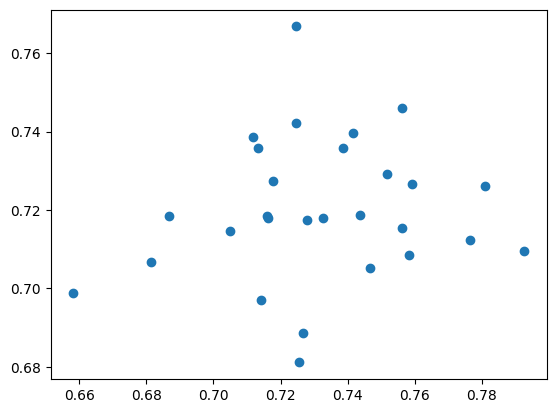

rank correlation = SignificanceResult(statistic=0.07717569786535304, pvalue=0.6962853459956213) 

correlation = 0.13510749550559314 

mean = 0.011561149931177458 | std_dev = 0.0329389912824427 



In [49]:
compare_ds(np.array(ds_gen_avg), np.array(ds_avg), "DS - GENERATED vs. REFERENCE")


BERTSCORE - GENERATED VS. REFERENCE


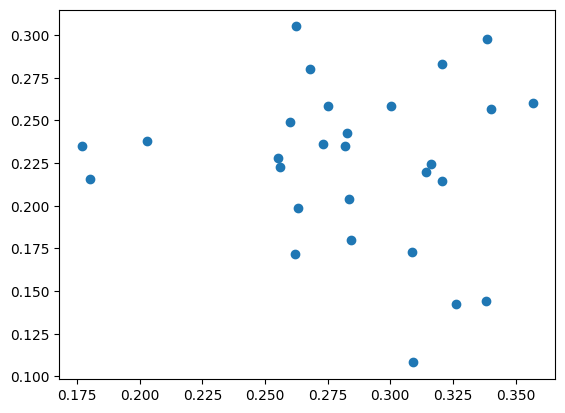

rank correlation = SignificanceResult(statistic=-0.01751505199781062, pvalue=0.9295095031118134) 

correlation = -0.08312343575260399 

mean = 0.059725436061699555 | std_dev = 0.06794383403105855 



In [54]:
compare_ds(np.array(bs_gen_avg), np.array(bs_avg), "BERTscore - GENERATED vs. REFERENCE")